In [1]:
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install seaborn
# !pip install kaggle

## IMPORTAR LIBRERIAS ESTANDAR

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

## DECLARAR FUNCIONES

In [3]:
def get_unpivoted(df, id_vars, var_name, value_name):
    '''
    parameters:
       id_vars: type list, variables ids sobre el cual se toma referencia para el unpivot
       var_name: type str, la nueva variable que se genera a partir de las columnas donde se aplica el unpivot
       value_name: typestr, el valor correspondiente a las variables ids y la nueva variable generada (target)
    return: type dataframe, el nuevo df transformado con el unpivot
    '''
    df = df.melt(id_vars=id_vars, var_name=var_name, value_name=value_name)
    return df

In [4]:
import datetime as dt
def get_dict_semana(since, semana_inicio, semana_fin):
    '''
    parameters:
        since: type str, con el sgte formato 'YYYY-MM-DD'
        semana_inicio: type int, semana inicio de la data
        semana_fin: type int, semana fin de la data
    return: type dict, donde key es la semana_xx y los values son los periodo de inicio y fin de la semana
        
    '''
    periodo_ini = dt.datetime.strptime(since,'%Y-%m-%d')
    list_periodo = []
    for i in range(semana_inicio-1, semana_fin):
        aux = ''
        if i<9:
            aux = '0'+str(i+1)
        else:
            aux = str(i+1)

        periodo_fin = periodo_ini + dt.timedelta(days=6)
        list_periodo.append(['SEMANA_'+aux, periodo_ini, periodo_fin ])
        periodo_ini = periodo_fin + dt.timedelta(days=1)

    dict_semana = {item[0]:{'periodo_ini': item[1], 'periodo_fin':item[2]} for item in list_periodo}
    return dict_semana

In [5]:
def managing_semana(df, dict_semana):
    '''
    Aplicar feature engineering a las variable SEMANA_XX
    '''
    if 'FECHA_INICIO' not in df.columns:
        df['FECHA_INICIO'] = df['SEMANA_XX'].apply(lambda x: dict_semana.get(x)['periodo_ini'])
        df['FECHA_FIN'] = df['SEMANA_XX'].apply(lambda x: dict_semana.get(x)['periodo_fin'])
    return df

In [6]:
def get_dict_categ(df, column):
    '''
    parameters:
      column: type str, se refiere a la variable categorica 
    return: type dict, retorna un key_value de los valores de las variable categorica
    '''
    dict_categ = {}
    for n,i in enumerate(df[column].unique()):
        dict_categ[i] = str(n+1) ### modificar colum
    return dict_categ

In [7]:
def map_valores_categ(df):
    df['Z_MARCA'] = df['Z_MARCA'].map(dict_marca)
    df['Z_MODELO'] = df['Z_MODELO'].map(dict_modelo)
    df['Z_DEPARTAMENTO'] = df['Z_DEPARTAMENTO'].map(dict_departamento)
    df['Z_PUNTO_VENTA'] = df['Z_PUNTO_VENTA'].map(dict_ptoventa)
    df['Z_GAMA'] = df['Z_GAMA'].map(dict_gama)
    return df

In [8]:
def get_feature_selection(fi):
    ##method: encontar las variables con una importancia acumulativa al 99% y las variables con zero importancia
    zero_importance = fi[fi==0]
    aux = fi[fi>0].sort_values(ascending=False)
    keep_columns = []
    count = 0
    for feature,values in zip(aux.index, aux.values):
        count+=values
        if count<=0.99:
            keep_columns.append(feature)
            
    print(f'total de variables : {len(fi)}')
    print(f'variables con importancia acumulada al 99% : {len(keep_columns)}')
    print(f'variables con zero importancia : {len(zero_importance)}')
    return keep_columns, zero_importance

In [9]:
def show_values_on_bars(axs, h_v="v", space=0.4, precision=1):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                val = p.get_height()
                if not str(p.get_height())=='nan':
                    value = val
                    if isinstance(value, float):
                        value = round(value, precision)
                    ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## LOAD DATA Y TRANSFORMACION

In [10]:
# /kaggle/input/datathon-entel-2022-reto2
ruta = '../data/'
train_raw = pd.read_csv(ruta+'train.csv')
test_raw =  pd.read_csv(ruta+'test.csv')

In [11]:
### unpivot
id_vars = ['Z_MARCA','Z_MODELO','Z_GAMA','Z_DEPARTAMENTO','Z_PUNTO_VENTA']
var_name = 'SEMANA_XX'
value_name = 'TARGET'

train_transform = get_unpivoted(train_raw, id_vars, var_name, value_name)
test_transform = get_unpivoted(test_raw, id_vars, var_name, value_name)
test_transform['TARGET'] = -1

In [12]:
### featuring engineering semana
dict_semana_train = get_dict_semana(since = '2021-05-17', semana_inicio = 1, semana_fin = 50)
dict_semana_test = get_dict_semana(since = '2022-05-02', semana_inicio = 51, semana_fin = 60)
train_transform = managing_semana(train_transform, dict_semana_train)
test_transform = managing_semana(test_transform, dict_semana_test)
train_transform.shape, test_transform.shape

((2358650, 9), (471730, 9))

In [13]:
## concat
demanda = pd.concat([train_transform, test_transform], axis=0)
demanda['TARGET'] = demanda['TARGET'].astype('int32')
demanda['ID'] = (demanda['Z_MODELO']+'|'+demanda['Z_PUNTO_VENTA']+'|'+ demanda['Z_GAMA']+'|'+demanda['SEMANA_XX'])
demanda.set_index('ID', inplace=True)
demanda.sort_values(['Z_MARCA', 'Z_MODELO', 'Z_GAMA', 'Z_DEPARTAMENTO','Z_PUNTO_VENTA','SEMANA_XX'], inplace=True)

In [14]:
### label_encoding variables categoricas
dict_marca = get_dict_categ(demanda, 'Z_MARCA')
dict_modelo = get_dict_categ(demanda, 'Z_MODELO')
dict_departamento = get_dict_categ(demanda, 'Z_DEPARTAMENTO')
dict_ptoventa = get_dict_categ(demanda, 'Z_PUNTO_VENTA')
dict_gama = get_dict_categ(demanda, 'Z_GAMA')
demanda = map_valores_categ(demanda)
demanda[['Z_MARCA', 'Z_MODELO', 'Z_GAMA', 'Z_DEPARTAMENTO','Z_PUNTO_VENTA','SEMANA_XX','FECHA_INICIO','FECHA_FIN','TARGET']].head()

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,FECHA_INICIO,FECHA_FIN,TARGET
ID,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,1,1,1,1,1,SEMANA_01,2021-05-17,2021-05-23,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,1,1,1,1,1,SEMANA_02,2021-05-24,2021-05-30,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,1,1,1,1,1,SEMANA_03,2021-05-31,2021-06-06,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,1,1,1,1,1,SEMANA_04,2021-06-07,2021-06-13,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,1,1,1,1,1,SEMANA_05,2021-06-14,2021-06-20,0


## EDA

In [15]:
demanda_train = demanda[demanda['TARGET']>=0].copy()
demanda_test = demanda[demanda['TARGET']<0].copy()

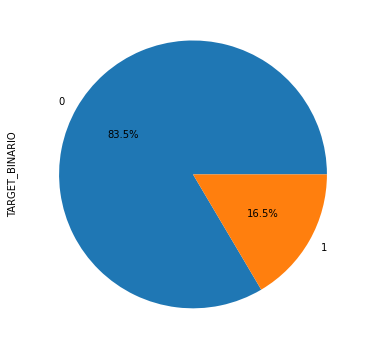

In [16]:
demanda_train['TARGET_BINARIO'] = demanda_train['TARGET'].apply(lambda x:  0 if x<1 else 1)
demanda_train['TARGET_BINARIO'].value_counts().plot.pie(autopct='%.1f%%', figsize=(6,8));

In [17]:
demanda_train[['Z_MARCA', 'Z_MODELO', 'Z_GAMA', 'Z_DEPARTAMENTO','Z_PUNTO_VENTA',
               'SEMANA_XX','FECHA_INICIO','FECHA_FIN','TARGET']].tail(50)

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,FECHA_INICIO,FECHA_FIN,TARGET
ID,,,,,,,,,
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,17,318,1,24,414,SEMANA_01,2021-05-17,2021-05-23,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,17,318,1,24,414,SEMANA_02,2021-05-24,2021-05-30,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,17,318,1,24,414,SEMANA_03,2021-05-31,2021-06-06,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,17,318,1,24,414,SEMANA_04,2021-06-07,2021-06-13,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,17,318,1,24,414,SEMANA_05,2021-06-14,2021-06-20,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_06,17,318,1,24,414,SEMANA_06,2021-06-21,2021-06-27,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_07,17,318,1,24,414,SEMANA_07,2021-06-28,2021-07-04,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_08,17,318,1,24,414,SEMANA_08,2021-07-05,2021-07-11,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_09,17,318,1,24,414,SEMANA_09,2021-07-12,2021-07-18,0


### Departamento

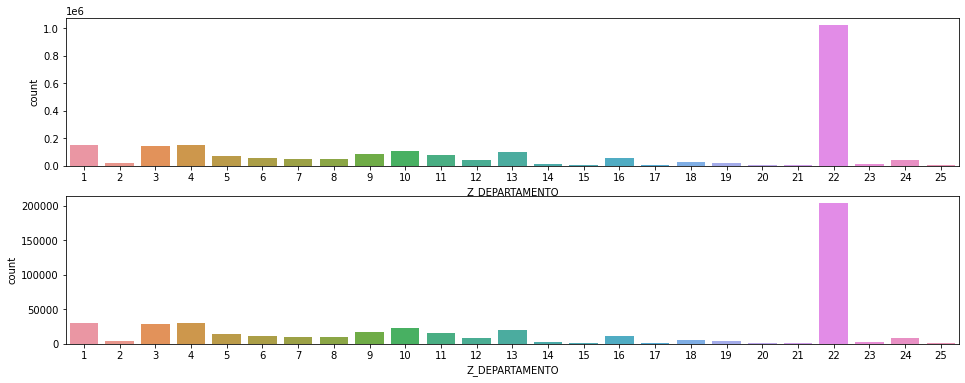

In [18]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))
sns.countplot(data=demanda_train, x='Z_DEPARTAMENTO', ax=axes[0]);
sns.countplot(data=demanda_test, x='Z_DEPARTAMENTO', ax=axes[1]);

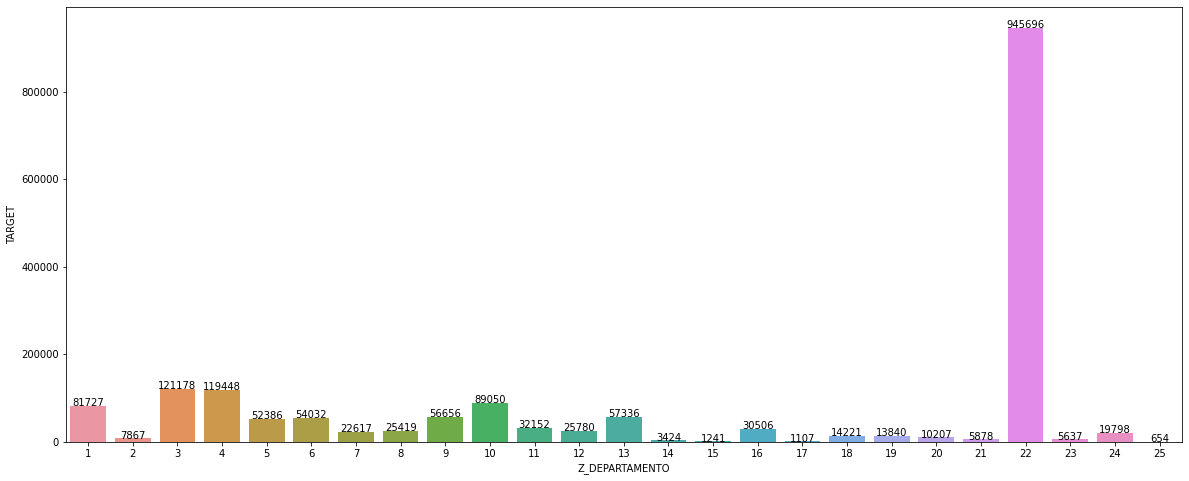

In [19]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

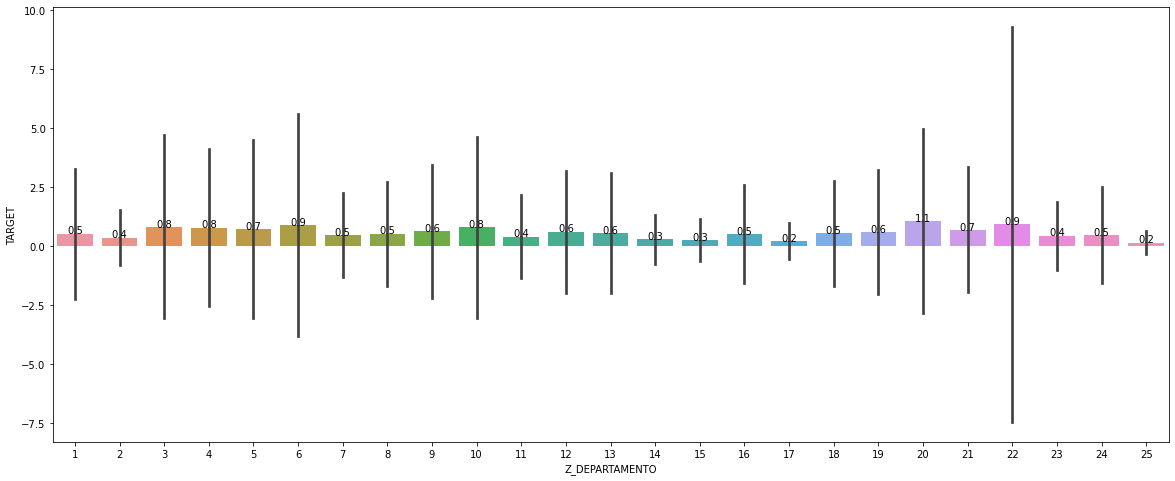

In [20]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

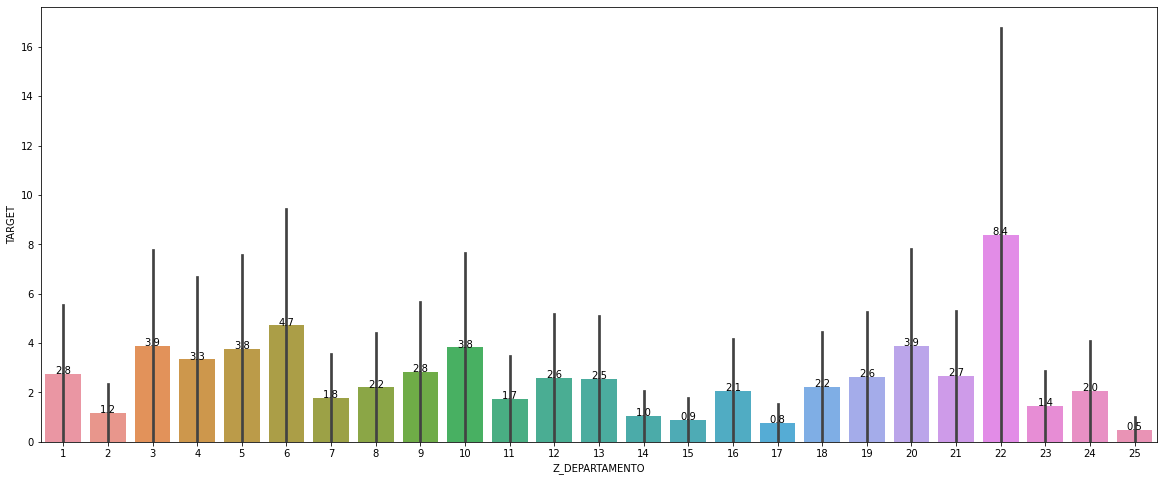

In [21]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.std, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

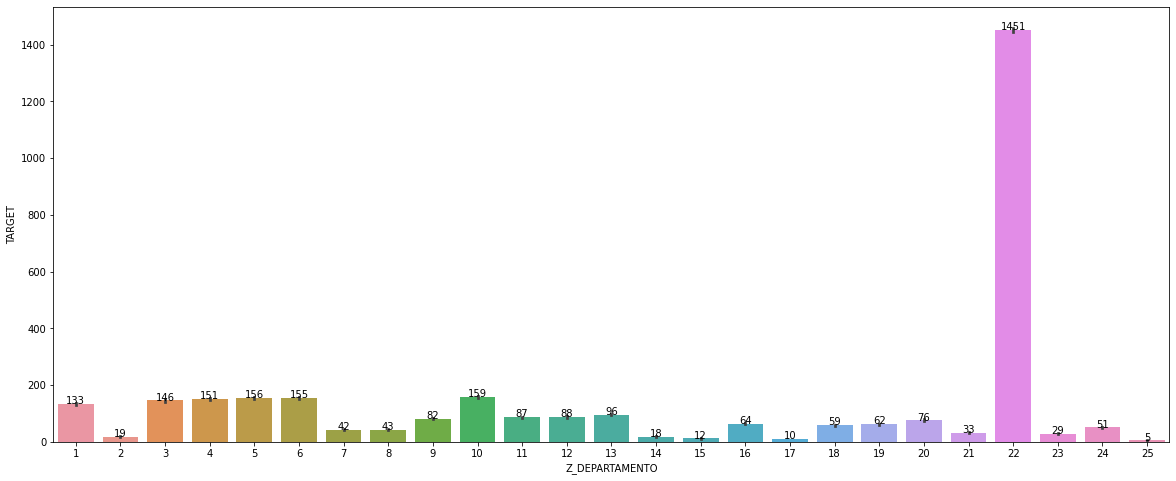

In [22]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

### Marca

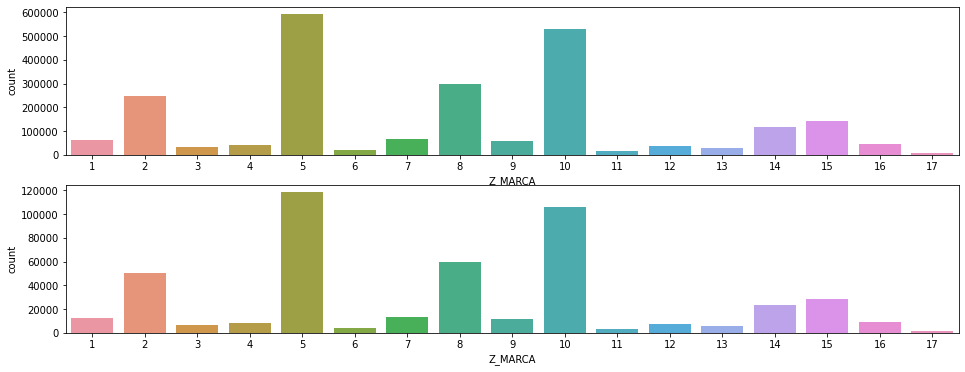

In [23]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))
sns.countplot(data=demanda_train, x='Z_MARCA', ax=axes[0]);
sns.countplot(data=demanda_test, x='Z_MARCA', ax=axes[1]);

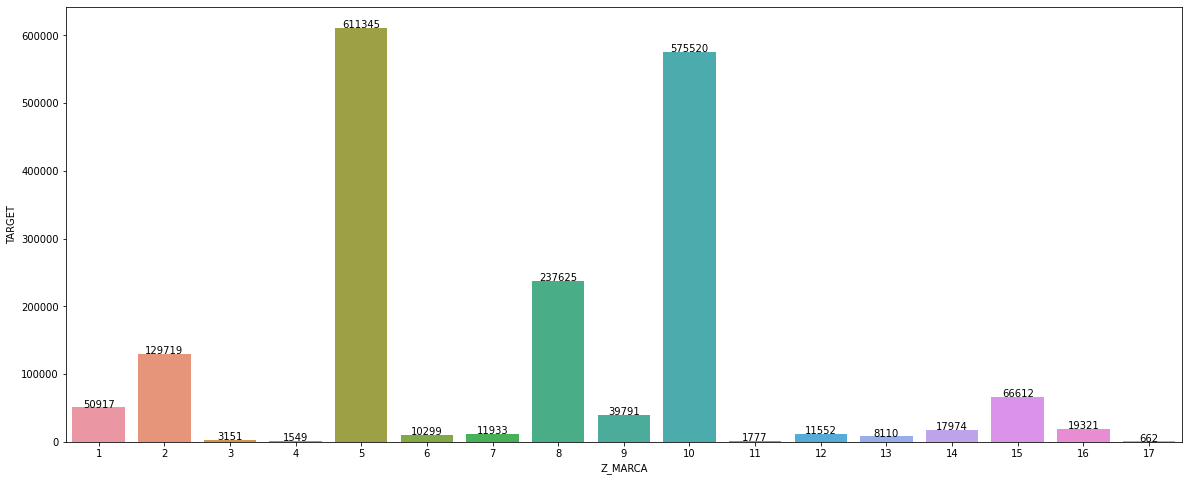

In [24]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

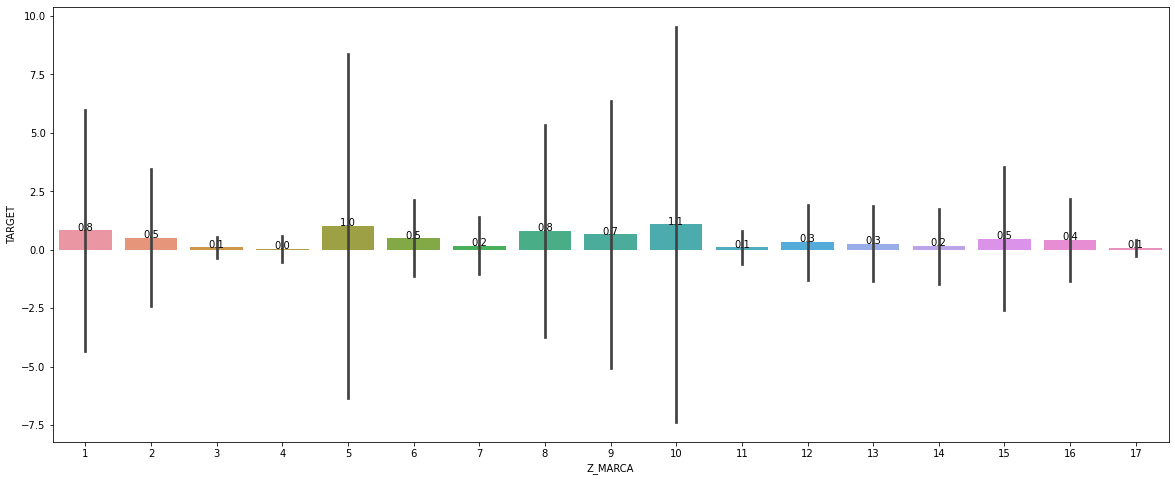

In [25]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

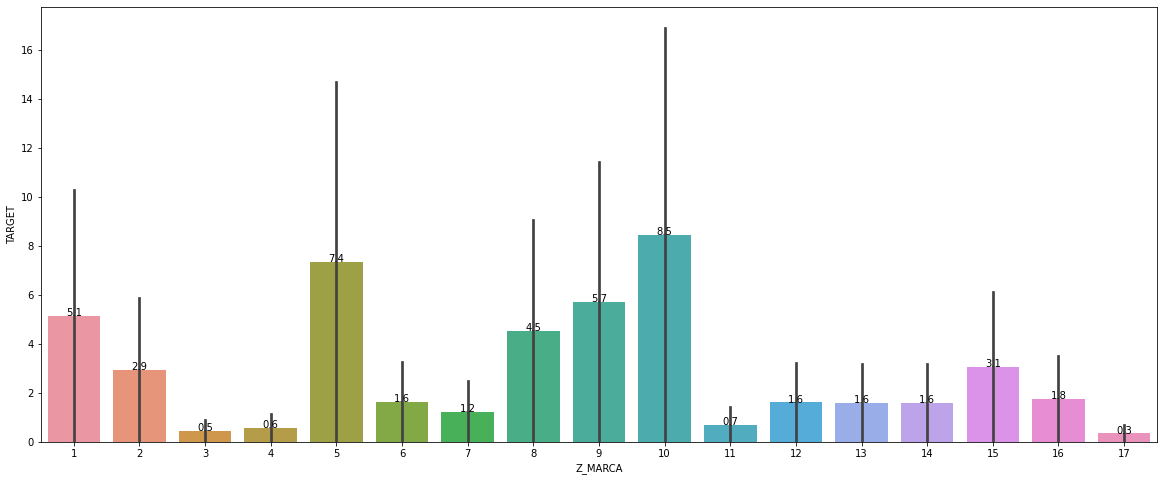

In [26]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.std, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

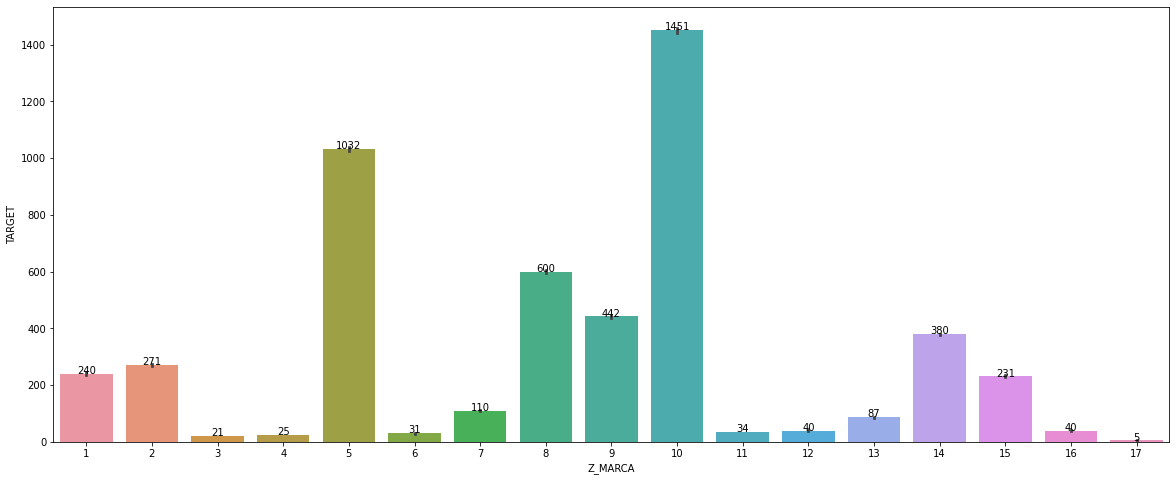

In [27]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

### Gama

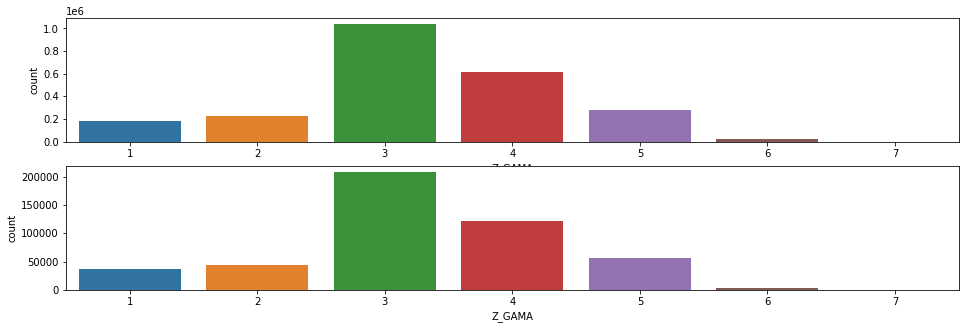

In [28]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 5))
sns.countplot(data=demanda_train, x='Z_GAMA', ax=axes[0]);
sns.countplot(data=demanda_test, x='Z_GAMA', ax=axes[1]);

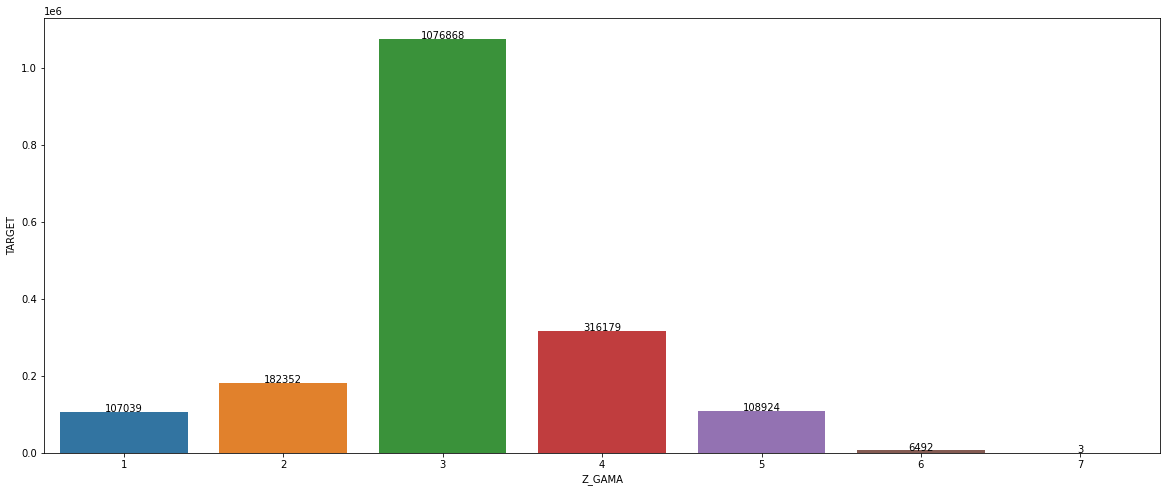

In [29]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

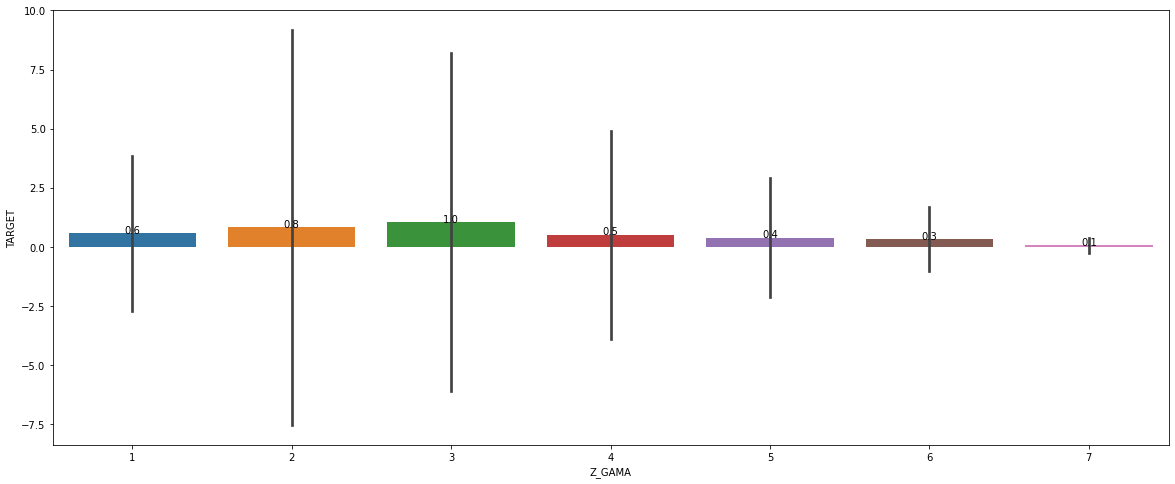

In [30]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

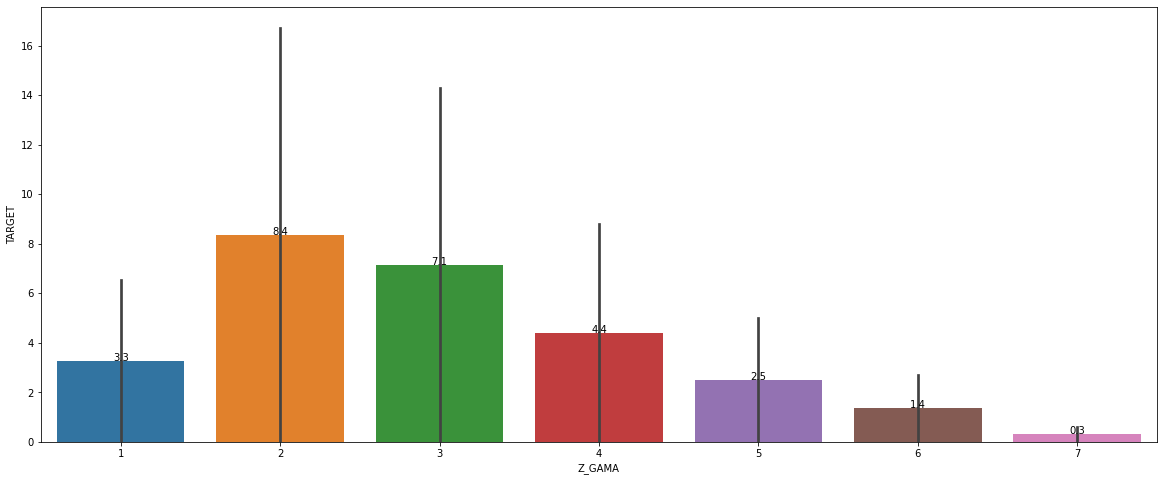

In [31]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.std, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

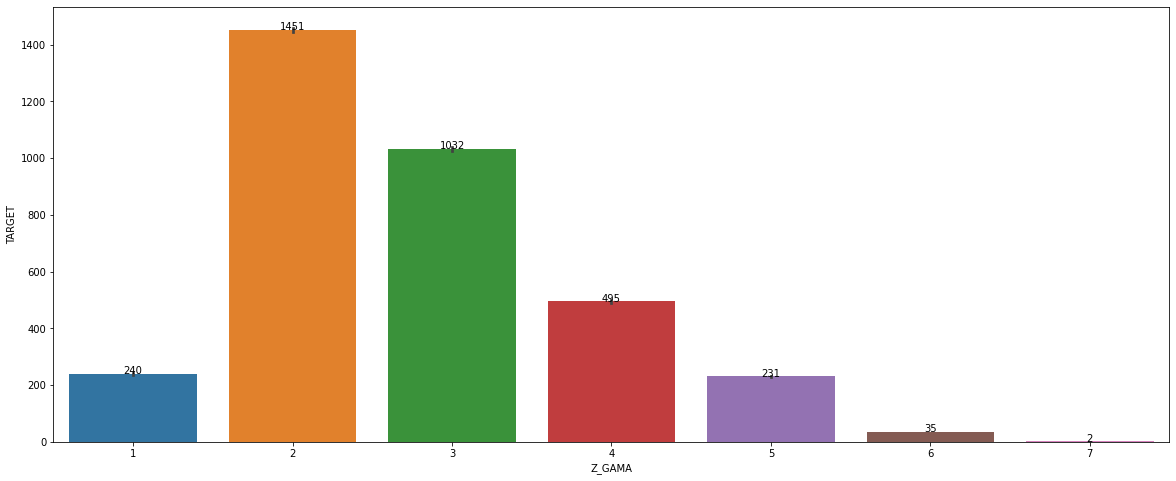

In [32]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

### Semana_XX

In [33]:
demanda_train['MES_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.strftime('%b'))
demanda_train['ANNIO_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.year)
demanda_train['DIA_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.day)
demanda_train['FECHA_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.strftime('%Y-%m-%d'))
demanda_train

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,TARGET,FECHA_INICIO,FECHA_FIN,TARGET_BINARIO,MES_INICIO,ANNIO_INICIO,DIA_INICIO
ID,,,,,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,1,1,1,1,1,SEMANA_01,0,2021-05-17,2021-05-23,0,May,2021,17
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,1,1,1,1,1,SEMANA_02,0,2021-05-24,2021-05-30,0,May,2021,24
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,1,1,1,1,1,SEMANA_03,0,2021-05-31,2021-06-06,0,May,2021,31
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,1,1,1,1,1,SEMANA_04,0,2021-06-07,2021-06-13,0,Jun,2021,7
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,1,1,1,1,1,SEMANA_05,0,2021-06-14,2021-06-20,0,Jun,2021,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_46,17,318,1,24,414,SEMANA_46,0,2022-03-28,2022-04-03,0,Mar,2022,28
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_47,17,318,1,24,414,SEMANA_47,0,2022-04-04,2022-04-10,0,Apr,2022,4
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_48,17,318,1,24,414,SEMANA_48,0,2022-04-11,2022-04-17,0,Apr,2022,11


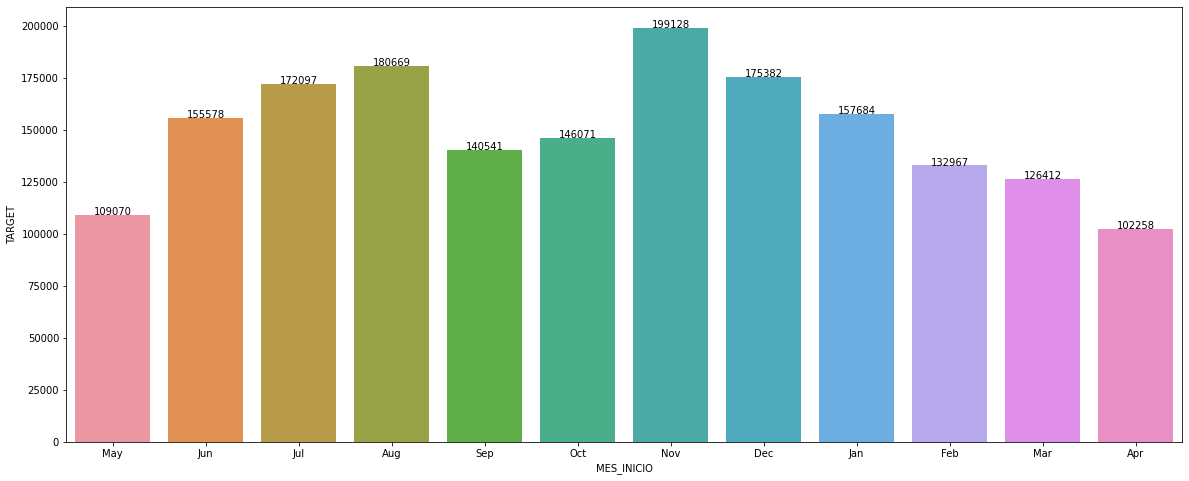

In [34]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='MES_INICIO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

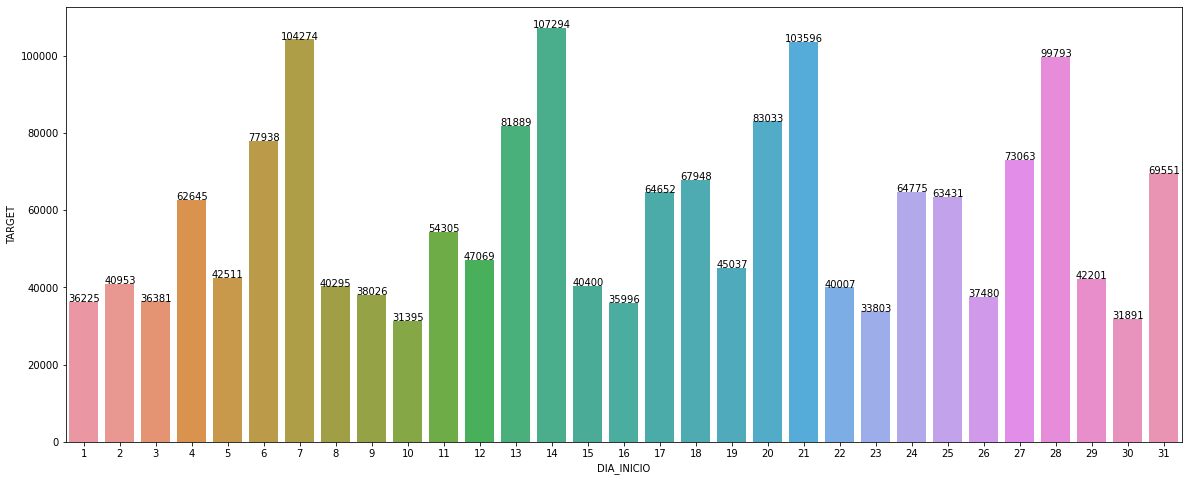

In [35]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='DIA_INICIO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

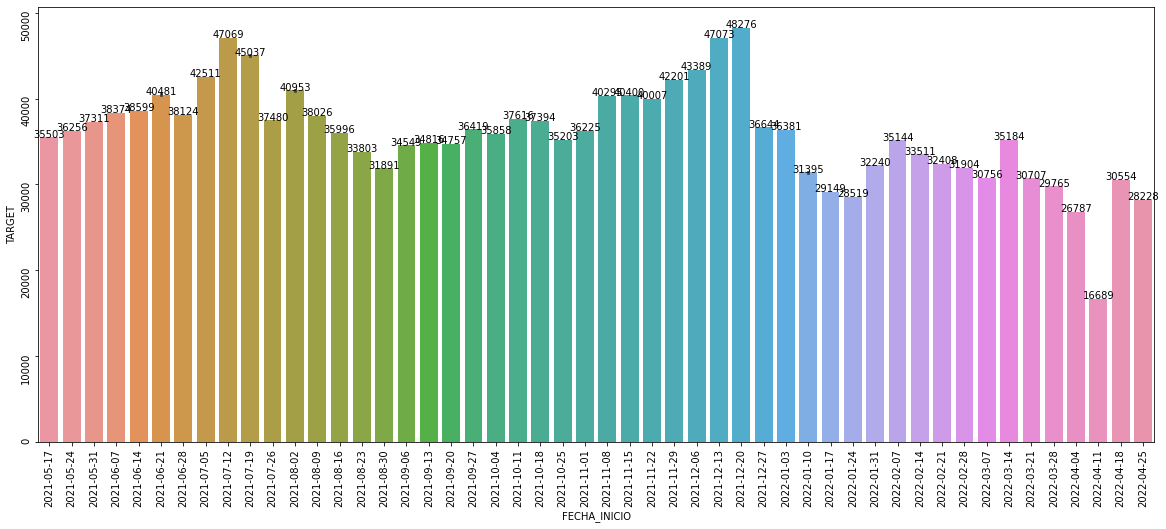

In [36]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='FECHA_INICIO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
axs.tick_params(rotation=90)
plt.show()

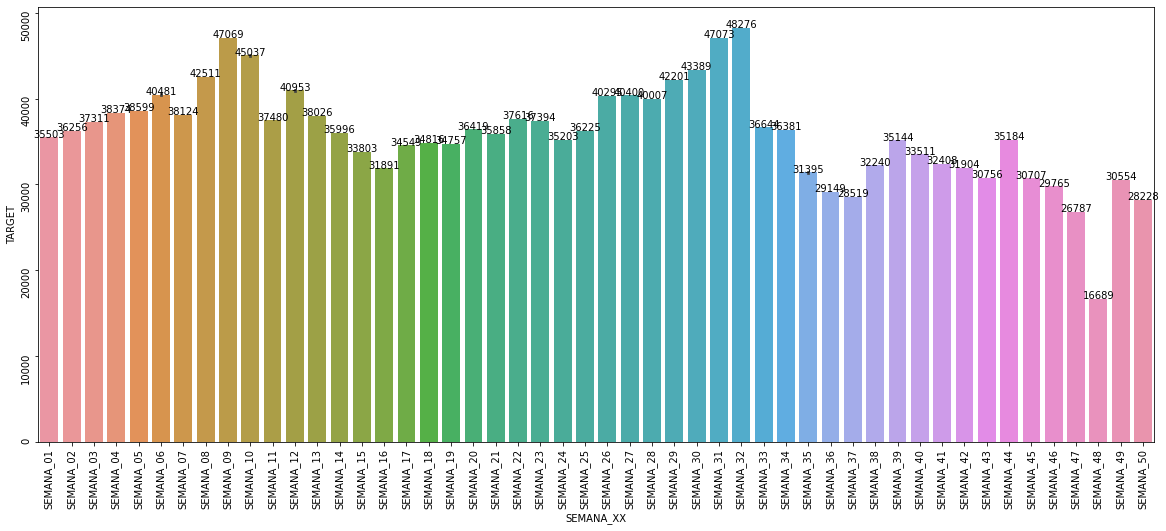

In [37]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
axs.tick_params(rotation=90)
plt.show()

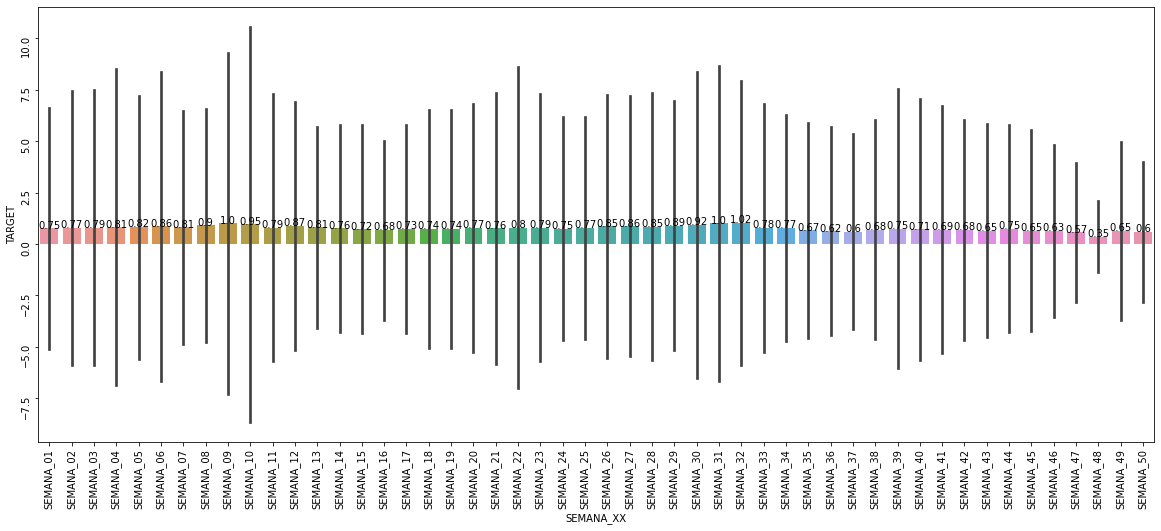

In [38]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8, precision=2)
axs.tick_params(rotation=90)
plt.show()

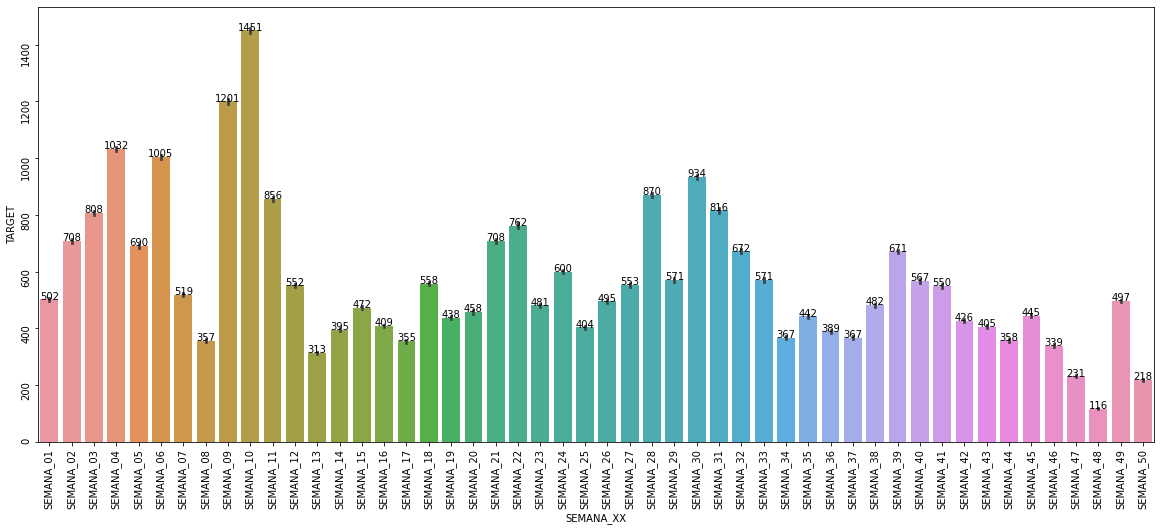

In [39]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8, precision=2)
axs.tick_params(rotation=90)
plt.show()

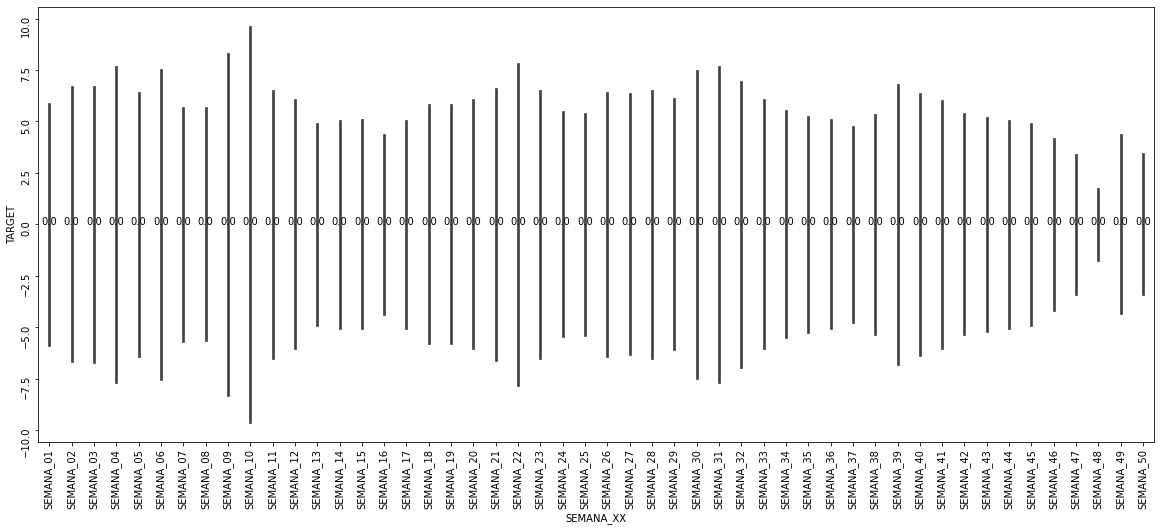

In [40]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.median, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8, precision=2)
axs.tick_params(rotation=90)
plt.show()

## FEATURE ENGINEERING

In [15]:
demanda['MES_INICIO'] = demanda['FECHA_INICIO'].apply(lambda x: x.month).astype('int32')
demanda['DIA_INICIO'] = demanda['FECHA_INICIO'].apply(lambda x: x.day).astype('int32')
demanda['ANNIO_INICIO'] = demanda['FECHA_INICIO'].apply(lambda x: x.year).astype('int32')
demanda['MES_FIN'] = demanda['FECHA_FIN'].apply(lambda x: x.month).astype('int32')
demanda['DIA_FIN'] = demanda['FECHA_FIN'].apply(lambda x: x.day).astype('int32')
# demanda['ANNIO_FIN'] = demanda['FECHA_FIN'].apply(lambda x: x.year).astype('int32')
demanda['ANNIO_SEMANA_FIN'] = (demanda['FECHA_FIN'].astype(str).str[:4] + demanda['SEMANA_XX'].str[-2:]).astype('int32')
demanda

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,TARGET,FECHA_INICIO,FECHA_FIN,MES_INICIO,DIA_INICIO,ANNIO_INICIO,MES_FIN,DIA_FIN,ANNIO_SEMANA_FIN
ID,,,,,,,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,1,1,1,1,1,SEMANA_01,0,2021-05-17,2021-05-23,5,17,2021,5,23,202101
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,1,1,1,1,1,SEMANA_02,0,2021-05-24,2021-05-30,5,24,2021,5,30,202102
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,1,1,1,1,1,SEMANA_03,0,2021-05-31,2021-06-06,5,31,2021,6,6,202103
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,1,1,1,1,1,SEMANA_04,0,2021-06-07,2021-06-13,6,7,2021,6,13,202104
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,1,1,1,1,1,SEMANA_05,0,2021-06-14,2021-06-20,6,14,2021,6,20,202105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_56,17,318,1,24,414,SEMANA_56,-1,2022-06-06,2022-06-12,6,6,2022,6,12,202256
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_57,17,318,1,24,414,SEMANA_57,-1,2022-06-13,2022-06-19,6,13,2022,6,19,202257
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_58,17,318,1,24,414,SEMANA_58,-1,2022-06-20,2022-06-26,6,20,2022,6,26,202258


In [16]:
demanda_train = demanda[demanda['TARGET']>=0].copy()

In [17]:
### 
mean_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.mean().to_dict()
mean_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.mean().to_dict()
mean_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.mean().to_dict()
mean_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.mean().to_dict()

###
std_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.std().to_dict()
std_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.std().to_dict()
std_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.std().to_dict()
std_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.std().to_dict()

###
max_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.max().to_dict()
max_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.max().to_dict()
max_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.max().to_dict()
max_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.max().to_dict()

###
sum_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.sum().to_dict()
sum_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.sum().to_dict()
sum_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.sum().to_dict()
sum_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.sum().to_dict()

In [18]:
#####
demanda['MODELO_mean_ENC'] = demanda['Z_MODELO'].map(mean_encoding_modelo)
demanda['PTOVENTA_mean_ENC'] = demanda['Z_PUNTO_VENTA'].map(mean_encoding_ptoventa)
demanda['MARCA_mean_ENC'] = demanda['Z_MARCA'].map(mean_encoding_marca)
demanda['GAMA_mean_ENC'] = demanda['Z_GAMA'].map(mean_encoding_gama)

#####
demanda['MODELO_std_ENC'] = demanda['Z_MODELO'].map(std_encoding_modelo)
demanda['PTOVENTA_std_ENC'] = demanda['Z_PUNTO_VENTA'].map(std_encoding_ptoventa)
demanda['MARCA_std_ENC'] = demanda['Z_MARCA'].map(std_encoding_marca)
demanda['GAMA_std_ENC'] = demanda['Z_GAMA'].map(std_encoding_gama)

#####
demanda['MODELO_max_ENC'] = demanda['Z_MODELO'].map(max_encoding_modelo)
demanda['PTOVENTA_max_ENC'] = demanda['Z_PUNTO_VENTA'].map(max_encoding_ptoventa)
demanda['MARCA_max_ENC'] = demanda['Z_MARCA'].map(max_encoding_marca)
demanda['GAMA_max_ENC'] = demanda['Z_GAMA'].map(max_encoding_gama)

#####
# demanda['MODELO_sum_ENC'] = demanda['Z_MODELO'].map(sum_encoding_modelo)
# demanda['PTOVENTA_sum_ENC'] = demanda['Z_PUNTO_VENTA'].map(sum_encoding_ptoventa)
demanda['MARCA_sum_ENC'] = demanda['Z_MARCA'].map(sum_encoding_marca)
demanda['GAMA_sum_ENC'] = demanda['Z_GAMA'].map(sum_encoding_gama)

In [19]:
demanda['PORC_MODELO_mean_max_ENC'] = demanda['MODELO_mean_ENC']/demanda['MODELO_max_ENC'] 
demanda['PORC_PTOVENTA_mean_max_ENC'] = demanda['PTOVENTA_mean_ENC']/demanda['PTOVENTA_max_ENC'] 
demanda['PORC_MARCA_mean_max_ENC'] = demanda['MARCA_mean_ENC']/demanda['MARCA_max_ENC']
demanda['PORC_GAMA_mean_max_ENC'] = demanda['GAMA_mean_ENC']/demanda['GAMA_max_ENC'] 

In [20]:
### Drop Columns
demanda2 = demanda.copy()
drop_columns =['Z_MARCA','Z_GAMA','Z_MODELO','Z_PUNTO_VENTA','Z_DEPARTAMENTO',
              'FECHA_INICIO','FECHA_FIN']
demanda2.drop(drop_columns, axis=1, inplace=True)
demanda2.columns

Index(['SEMANA_XX', 'TARGET', 'MES_INICIO', 'DIA_INICIO', 'ANNIO_INICIO',
       'MES_FIN', 'DIA_FIN', 'ANNIO_SEMANA_FIN', 'MODELO_mean_ENC',
       'PTOVENTA_mean_ENC', 'MARCA_mean_ENC', 'GAMA_mean_ENC',
       'MODELO_std_ENC', 'PTOVENTA_std_ENC', 'MARCA_std_ENC', 'GAMA_std_ENC',
       'MODELO_max_ENC', 'PTOVENTA_max_ENC', 'MARCA_max_ENC', 'GAMA_max_ENC',
       'MARCA_sum_ENC', 'GAMA_sum_ENC', 'PORC_MODELO_mean_max_ENC',
       'PORC_PTOVENTA_mean_max_ENC', 'PORC_MARCA_mean_max_ENC',
       'PORC_GAMA_mean_max_ENC'],
      dtype='object')

In [22]:
aux = demanda2.corr().apply(lambda x: np.abs(round(x, 4)), axis=1)
list_result = []
for i in range(len(aux)):
    res = aux.iloc[i].sort_values(ascending=False)
    list_result.append([res.index[0], res.index[1], res.values[1]])

In [23]:
pd.DataFrame(list_result, columns=['A','B', 'COR']).sort_values('COR',ascending=False)
# list_result

,A,B,COR
14,GAMA_std_ENC,GAMA_max_ENC,0.9873
18,GAMA_max_ENC,GAMA_std_ENC,0.9873
12,PTOVENTA_std_ENC,PTOVENTA_mean_ENC,0.9792
8,PTOVENTA_mean_ENC,PTOVENTA_std_ENC,0.9792
7,MODELO_mean_ENC,MODELO_std_ENC,0.9755
11,MODELO_std_ENC,MODELO_mean_ENC,0.9755
13,MARCA_std_ENC,MARCA_mean_ENC,0.9698
9,MARCA_mean_ENC,MARCA_std_ENC,0.9698
6,ANNIO_SEMANA_FIN,ANNIO_INICIO,0.9653
3,ANNIO_INICIO,ANNIO_SEMANA_FIN,0.9653


In [24]:
demanda2.isna().sum()

SEMANA_XX                         0
TARGET                            0
MES_INICIO                        0
DIA_INICIO                        0
ANNIO_INICIO                      0
MES_FIN                           0
DIA_FIN                           0
ANNIO_SEMANA_FIN                  0
MODELO_mean_ENC                   0
PTOVENTA_mean_ENC                 0
MARCA_mean_ENC                    0
GAMA_mean_ENC                     0
MODELO_std_ENC                    0
PTOVENTA_std_ENC                  0
MARCA_std_ENC                     0
GAMA_std_ENC                      0
MODELO_max_ENC                    0
PTOVENTA_max_ENC                  0
MARCA_max_ENC                     0
GAMA_max_ENC                      0
MARCA_sum_ENC                     0
GAMA_sum_ENC                      0
PORC_MODELO_mean_max_ENC      95460
PORC_PTOVENTA_mean_max_ENC     5040
PORC_MARCA_mean_max_ENC           0
PORC_GAMA_mean_max_ENC            0
dtype: int64

## ENTRENAMIENTO 

In [25]:
demanda2['SEMANA_XX'] = demanda2['SEMANA_XX'].astype(str).str[-2:].astype('int32')

In [26]:
y_train = demanda2[demanda2['TARGET']>=0][['TARGET']].copy()
train = demanda2[demanda2['TARGET']>=0].copy()
test = demanda2[demanda2['TARGET']<0].copy()
train.shape, test.shape, y_train.shape

((2358650, 26), (471730, 26), (2358650, 1))

In [27]:
folds = []
folds.append(list(train[(train['SEMANA_XX']>=1) & (train['SEMANA_XX']<=10)].index))
folds.append(list(train[(train['SEMANA_XX']>=11) & (train['SEMANA_XX']<=20)].index))
folds.append(list(train[(train['SEMANA_XX']>=21) & (train['SEMANA_XX']<=30)].index))
folds.append(list(train[(train['SEMANA_XX']>=31) & (train['SEMANA_XX']<=40)].index))
folds.append(list(train[(train['SEMANA_XX']>=41) & (train['SEMANA_XX']<=50)].index))
len(folds), len(folds[0])

(5, 471730)

In [28]:
np.save('../data/folds.npy', folds)

In [29]:
train.drop(['SEMANA_XX', 'TARGET'], axis=1, inplace=True)
test.drop(['SEMANA_XX', 'TARGET'], axis=1, inplace=True)
train.shape, test.shape

((2358650, 24), (471730, 24))

In [30]:
demanda2.to_pickle('../data/preprocessed/demanda2.pkl')
train.to_pickle('../data/preprocessed/train.pkl')
test.to_pickle('../data/preprocessed/test.pkl')
y_train.to_pickle('../data/preprocessed/y_train.pkl')

## CATBOOST

In [31]:
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import ParameterGrid

params = ParameterGrid({"max_depth":[12], "learning_rate":[0.2]})

for param in params:
    fi = []
    test_probs = []
    train_probs = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.drop(idx)
        yt = y_train.loc[Xt.index].TARGET

        Xv = train.loc[idx]
        yv = y_train.loc[Xv.index].TARGET

        learner = CatBoostRegressor(**param, n_estimators=1000, eval_metric = 'RMSE', random_state=42)
        # learner = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42, )

        learner.fit(Xt, yt,  early_stopping_rounds=10, 
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=100)

        test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

    train_probs = pd.concat(train_probs)
    train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

    fi = pd.concat(fi, axis=1).mean(axis=1)
    score = mean_squared_error(y_train.loc[train.index].TARGET, train_probs.loc[train.index], squared=False)
    print(param)
    print('SCORE RMSE: ', score)

********** 0 **********
0:	learn: 5.0563696	test: 5.0563696	test1: 6.6002296	best: 6.6002296 (0)	total: 761ms	remaining: 12m 40s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 4.615422245
bestIteration = 85

Shrink model to first 86 iterations.
********** 1 **********
0:	learn: 5.4851735	test: 5.4851735	test1: 4.9120653	best: 4.9120653 (0)	total: 491ms	remaining: 8m 10s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 3.557536115
bestIteration = 8

Shrink model to first 9 iterations.
********** 2 **********
0:	learn: 5.2532623	test: 5.2532623	test1: 6.1118523	best: 6.1118523 (0)	total: 501ms	remaining: 8m 20s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 3.893854189
bestIteration = 53

Shrink model to first 54 iterations.
********** 3 **********
0:	learn: 5.3743221	test: 5.3743221	test1: 5.6400469	best: 5.6400469 (0)	total: 517ms	remaining: 8m 36s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 3.614292903
bestIt

In [32]:
train_probs.name='probs_cb'
test_probs.name='probs_cb'
train_probs.to_pickle('../data/preprocessed/catboost/train_probs.pkl')
test_probs.to_pickle('../data/preprocessed/catboost/test_probs.pkl')
fi.sort_values(ascending=False).to_pickle('../data/preprocessed/catboost/fi.pkl')

#### Visualizacion de resultados

In [33]:
fi.sort_values(ascending=False)

PTOVENTA_mean_ENC             0.148208
ANNIO_SEMANA_FIN              0.145027
MODELO_mean_ENC               0.131301
PTOVENTA_std_ENC              0.123781
MODELO_std_ENC                0.069835
MODELO_max_ENC                0.064177
PORC_MODELO_mean_max_ENC      0.060302
PTOVENTA_max_ENC              0.042697
MES_INICIO                    0.039454
PORC_PTOVENTA_mean_max_ENC    0.032509
GAMA_mean_ENC                 0.027081
MES_FIN                       0.020742
PORC_MARCA_mean_max_ENC       0.017114
MARCA_sum_ENC                 0.013112
MARCA_mean_ENC                0.012659
MARCA_std_ENC                 0.012299
GAMA_sum_ENC                  0.011418
MARCA_max_ENC                 0.007057
PORC_GAMA_mean_max_ENC        0.005492
DIA_FIN                       0.005331
DIA_INICIO                    0.003629
ANNIO_INICIO                  0.003315
GAMA_std_ENC                  0.002786
GAMA_max_ENC                  0.000675
dtype: float64

In [34]:
test_probs.sort_values().unique()

array([0.00000000e+00, 3.65955117e-05, 8.38771433e-05, ...,
       2.18585342e+02, 2.23943125e+02, 2.31489204e+02])

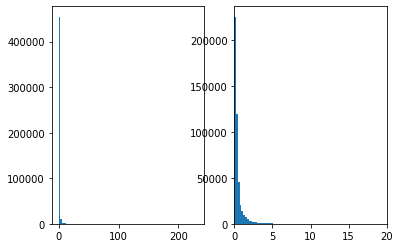

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test_probs, bins=100);
ax2.hist(test_probs, bins=1000);
plt.xlim(0,20);

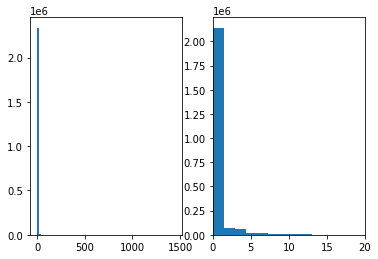

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [37]:
test_probs.describe()

count    471730.000000
mean          0.617511
std           2.364647
min           0.000000
25%           0.158891
50%           0.241869
75%           0.491954
max         231.489204
Name: probs_cb, dtype: float64

In [38]:
test_probs_cb = test_probs.copy()

## LIGHT GBM

In [40]:
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import ParameterGrid

params = ParameterGrid({ 'max_depth':[15], 'learning_rate':[0.2], 'num_leaves':[100], 'min_split_gain':[0.1] })

for param in params:
    fi = []
    test_probs = []
    train_probs = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.drop(idx)
        yt = y_train.loc[Xt.index].TARGET

        Xv = train.loc[idx]
        yv = y_train.loc[Xv.index].TARGET

        learner = LGBMRegressor(n_estimators=1000,  random_state=42, n_jobs=-1, **param)
        # learner = LGBMRegressor(n_estimators=1000,  random_state=42)
        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

        test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

    train_probs = pd.concat(train_probs)
    train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

    fi = pd.concat(fi, axis=1).mean(axis=1)
    score = mean_squared_error(y_train.loc[train.index].TARGET, train_probs.loc[train.index], squared=False)
    print(param)
    print('SCORE RMSE: ', score)

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 2.91483	training's l2: 8.49623	valid_1's rmse: 5.41573	valid_1's l2: 29.3302
[20]	training's rmse: 2.46151	training's l2: 6.05905	valid_1's rmse: 5.08302	valid_1's l2: 25.8371
[30]	training's rmse: 2.25751	training's l2: 5.09636	valid_1's rmse: 4.81797	valid_1's l2: 23.2129
[40]	training's rmse: 2.13172	training's l2: 4.54422	valid_1's rmse: 4.70235	valid_1's l2: 22.1121
[50]	training's rmse: 2.05539	training's l2: 4.22464	valid_1's rmse: 4.655	valid_1's l2: 21.669
[60]	training's rmse: 1.98408	training's l2: 3.93657	valid_1's rmse: 4.62545	valid_1's l2: 21.3947
[70]	training's rmse: 1.92603	training's l2: 3.70961	valid_1's rmse: 4.62211	valid_1's l2: 21.3639
********** 1 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.35651	training's l2: 11.2662	valid_1's rmse: 3.46842	valid_1's l2: 12.03
[20]	training's rmse: 2.74509	training's l2: 7.5355	valid_1's rmse: 3.60509	valid_1's l2: 12.9967
********** 2 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.04986	training's l2: 9.30163	valid_1's rmse: 4.55519	valid_1's l2: 20.7497
[20]	training's rmse: 2.60479	training's l2: 6.78493	valid_1's rmse: 4.39449	valid_1's l2: 19.3115
[30]	training's rmse: 2.34976	training's l2: 5.52135	valid_1's rmse: 4.24723	valid_1's l2: 18.0389
[40]	training's rmse: 2.23297	training's l2: 4.98614	valid_1's rmse: 4.22132	valid_1's l2: 17.8195
[50]	training's rmse: 2.16536	training's l2: 4.68879	valid_1's rmse: 4.20463	valid_1's l2: 17.6789
[60]	training's rmse: 2.08463	training's l2: 4.34567	valid_1's rmse: 4.1985	valid_1's l2: 17.6274
[70]	training's rmse: 2.04036	training's l2: 4.16305	valid_1's rmse: 4.1821	valid_1's l2: 17.4899
[80]	training's rmse: 1.97181	training's l2: 3.88804	valid_1's rmse: 4.15187	valid_1's l2: 17.238
[90]	training's rmse: 1.92061	training's l2: 3.68873	valid_1's rmse: 4.14988	valid_1's l2: 17.2215
[100]	training's rmse: 1.87913	training's l2: 3.53113	valid_1's rmse: 4.12604	valid_1's l2: 17.0242
[110]	traini

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.16161	training's l2: 9.99578	valid_1's rmse: 3.92354	valid_1's l2: 15.3942
[20]	training's rmse: 2.66083	training's l2: 7.08004	valid_1's rmse: 3.70968	valid_1's l2: 13.7617
[30]	training's rmse: 2.41073	training's l2: 5.81163	valid_1's rmse: 3.67341	valid_1's l2: 13.494
[40]	training's rmse: 2.27197	training's l2: 5.16184	valid_1's rmse: 3.65034	valid_1's l2: 13.325
[50]	training's rmse: 2.18718	training's l2: 4.78373	valid_1's rmse: 3.62143	valid_1's l2: 13.1147
[60]	training's rmse: 2.11784	training's l2: 4.48526	valid_1's rmse: 3.59427	valid_1's l2: 12.9188
[70]	training's rmse: 2.03791	training's l2: 4.15308	valid_1's rmse: 3.58468	valid_1's l2: 12.8499
[80]	training's rmse: 1.98349	training's l2: 3.93422	valid_1's rmse: 3.58723	valid_1's l2: 12.8682
********** 4 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.26852	training's l2: 10.6832	valid_1's rmse: 4.03495	valid_1's l2: 16.2808
{'learning_rate': 0.2, 'max_depth': 15, 'min_split_gain': 0.1, 'num_leaves': 100}
SCORE RMSE:  3.9170636789333937


In [41]:
train_probs.name='probs_lg'
test_probs.name='probs_lg'
train_probs.to_pickle('../data/preprocessed/lightgbm/train_probs.pkl')
test_probs.to_pickle('../data/preprocessed/lightgbm/test_probs.pkl')
fi.sort_values(ascending=False).to_pickle('../data/preprocessed/lightgbm/fi.pkl')

#### Visualizacion de resultados

In [42]:
fi.sort_values(ascending=False)

MODELO_mean_ENC               0.197385
ANNIO_SEMANA_FIN              0.170693
PTOVENTA_mean_ENC             0.161064
MES_INICIO                    0.060773
MODELO_max_ENC                0.056315
MODELO_std_ENC                0.048468
PTOVENTA_std_ENC              0.047061
PORC_MODELO_mean_max_ENC      0.046761
MES_FIN                       0.039098
PTOVENTA_max_ENC              0.033328
MARCA_mean_ENC                0.032931
PORC_PTOVENTA_mean_max_ENC    0.027692
GAMA_mean_ENC                 0.024426
DIA_INICIO                    0.019363
DIA_FIN                       0.017013
MARCA_sum_ENC                 0.006634
PORC_MARCA_mean_max_ENC       0.003718
MARCA_std_ENC                 0.002301
GAMA_std_ENC                  0.002021
GAMA_sum_ENC                  0.001653
MARCA_max_ENC                 0.001021
PORC_GAMA_mean_max_ENC        0.000224
ANNIO_INICIO                  0.000057
GAMA_max_ENC                  0.000000
dtype: float64

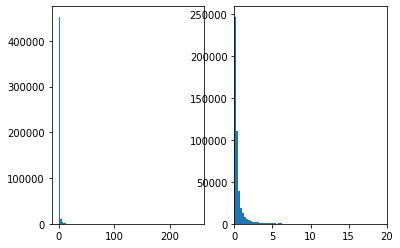

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test_probs, bins=100);
ax2.hist(test_probs, bins=1000);
plt.xlim(0,20);

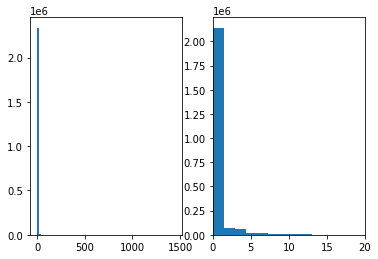

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [45]:
test_probs.describe()

count    471730.000000
mean          0.674900
std           2.798189
min           0.000000
25%           0.161187
50%           0.239631
75%           0.483598
max         249.535554
Name: probs_lg, dtype: float64

In [46]:
test_probs_lg = test_probs.copy()

## XGBOOST

In [47]:
from sklearn.metrics import mean_squared_error
from xgboost  import XGBRegressor
from sklearn.model_selection import ParameterGrid
params = ParameterGrid({"max_depth":[17], 'learning_rate':[0.2]})
for param in params:
    fi = []
    test_probs = []
    train_probs = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.drop(idx)
        yt = y_train.loc[Xt.index].TARGET

        Xv = train.loc[idx]
        yv = y_train.loc[Xv.index].TARGET

        # learner = XGBRegressor(n_estimators=1000,  random_state=42, **param)
        learner = XGBRegressor(n_estimators=1000,  random_state=42, n_jobs=-1, **param)
        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

        test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

    train_probs = pd.concat(train_probs)
    train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

    fi = pd.concat(fi, axis=1).mean(axis=1)
    score = mean_squared_error(y_train.loc[train.index].TARGET, train_probs.loc[train.index], squared=False)
    print(param)
    print('SCORE RMSE: ', score)

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:4.75284	validation_1-rmse:6.49950
[10]	validation_0-rmse:1.32184	validation_1-rmse:4.87514
[20]	validation_0-rmse:0.74556	validation_1-rmse:4.77360
[30]	validation_0-rmse:0.59123	validation_1-rmse:4.76353
[37]	validation_0-rmse:0.54254	validation_1-rmse:4.76632
********** 1 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.14288	validation_1-rmse:4.55974
[10]	validation_0-rmse:1.44373	validation_1-rmse:3.83082
[15]	validation_0-rmse:0.99772	validation_1-rmse:4.28500
********** 2 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:4.91646	validation_1-rmse:5.68852
[10]	validation_0-rmse:1.32960	validation_1-rmse:3.96531
[18]	validation_0-rmse:0.80705	validation_1-rmse:4.08545
********** 3 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.02113	validation_1-rmse:5.23229
[10]	validation_0-rmse:1.39049	validation_1-rmse:3.50412
[20]	validation_0-rmse:0.74118	validation_1-rmse:3.56175
[21]	validation_0-rmse:0.71519	validation_1-rmse:3.57189
********** 4 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.29704	validation_1-rmse:3.97104
[10]	validation_0-rmse:1.41381	validation_1-rmse:4.41141
[12]	validation_0-rmse:1.19567	validation_1-rmse:4.55044
{'learning_rate': 0.2, 'max_depth': 17}
SCORE RMSE:  3.866896977285611


In [48]:
train_probs.name='probs_xg'
test_probs.name='probs_xg'
train_probs.to_pickle('../data/preprocessed/xgboost/train_probs.pkl')
test_probs.to_pickle('../data/preprocessed/xgboost/test_probs.pkl')
fi.sort_values(ascending=False).to_pickle('../data/preprocessed/xgboost/fi.pkl')

#### Visualizacion de resultados

In [49]:
fi.sort_values(ascending=False)

MODELO_std_ENC                0.244872
GAMA_mean_ENC                 0.093409
MODELO_mean_ENC               0.088530
MODELO_max_ENC                0.085285
ANNIO_SEMANA_FIN              0.083884
PORC_MODELO_mean_max_ENC      0.075711
MARCA_mean_ENC                0.066364
PTOVENTA_mean_ENC             0.046288
MARCA_sum_ENC                 0.035339
PTOVENTA_std_ENC              0.033280
MES_INICIO                    0.031048
MES_FIN                       0.028939
PORC_MARCA_mean_max_ENC       0.025012
MARCA_std_ENC                 0.017088
GAMA_std_ENC                  0.011651
DIA_FIN                       0.007841
MARCA_max_ENC                 0.007782
GAMA_sum_ENC                  0.005489
DIA_INICIO                    0.005215
PTOVENTA_max_ENC              0.004013
PORC_PTOVENTA_mean_max_ENC    0.002958
GAMA_max_ENC                  0.000000
ANNIO_INICIO                  0.000000
PORC_GAMA_mean_max_ENC        0.000000
dtype: float32

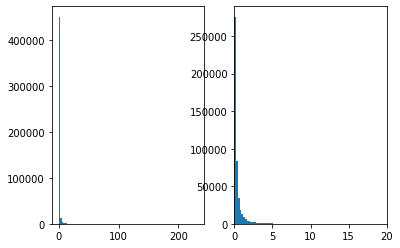

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test_probs, bins=100);
ax2.hist(test_probs, bins=1000);
plt.xlim(0,20);

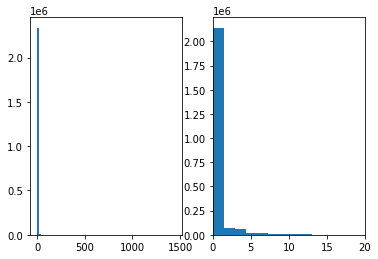

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [52]:
test_probs.describe()

count    471730.000000
mean          0.626905
std           2.390778
min           0.000000
25%           0.108815
50%           0.180535
75%           0.439905
max         231.453461
Name: probs_xg, dtype: float64

In [53]:
test_probs_xg = test_probs.copy()

## SUBMISION

In [54]:
# test_probs = test_probs_cb*0.55 + test_probs_lg*0.45
# test_probs = test_probs_cb.copy()
# test_probs = test_probs_lg.copy()
test_probs = test_probs_xg.copy()
test_probs.name = 'Demanda'
test_submit = test_probs.reset_index()[['ID','Demanda']]
test_submit

,ID,Demanda
0,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.254597
1,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.281150
2,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.327496
3,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.326105
4,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.291480
...,...,...
471725,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.107163
471726,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.104670
471727,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.103980
471728,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.104539


In [54]:
test_submit['Demanda'].describe()

count    471730.000000
mean          0.621364
std           2.319212
min           0.000000
25%           0.112507
50%           0.184381
75%           0.434693
max         234.555252
Name: Demanda, dtype: float64

In [55]:
test_submit.to_csv('../results/test_cv_xg.csv', index=False)

In [56]:
!kaggle competitions submit datathon-entel-2022-reto2 -f ../results/test_cv_xg.csv -m "test"

Successfully submitted to DATATHON ENTEL 2022 - Reto2



  0%|          | 0.00/101M [00:00<?, ?B/s]
  0%|          | 8.00k/101M [00:00<35:06, 50.5kB/s]
  0%|          | 208k/101M [00:00<03:03, 578kB/s]  
  1%|          | 888k/101M [00:00<00:44, 2.35MB/s]
  1%|1         | 1.23M/101M [00:00<00:38, 2.73MB/s]
  2%|1         | 1.65M/101M [00:00<00:32, 3.20MB/s]
  2%|1         | 2.02M/101M [00:01<01:09, 1.49MB/s]
  2%|2         | 2.47M/101M [00:01<00:52, 1.99MB/s]
  3%|2         | 2.94M/101M [00:01<00:41, 2.50MB/s]
  3%|3         | 3.41M/101M [00:01<00:34, 3.01MB/s]
  4%|3         | 3.86M/101M [00:01<00:30, 3.38MB/s]
  5%|4         | 4.80M/101M [00:01<00:21, 4.80MB/s]
  5%|5         | 5.34M/101M [00:02<00:55, 1.83MB/s]
  6%|5         | 5.81M/101M [00:02<00:47, 2.13MB/s]
  6%|6         | 6.21M/101M [00:02<00:44, 2.23MB/s]
  6%|6         | 6.56M/101M [00:03<00:43, 2.27MB/s]
  7%|6         | 6.88M/101M [00:03<00:43, 2.29MB/s]
  7%|7         | 7.17M/101M [00:03<00:42, 2.30MB/s]
  7%|7         | 7.45M/101M [00:03<00:42, 2.34MB/s]
  8%|7         | 7.71

## Entrenamiento con toda la data

In [55]:
punto_corte = 202249
Xt = train[train['ANNIO_SEMANA_FIN']<=punto_corte]
Xv = train[train['ANNIO_SEMANA_FIN']>punto_corte]
yt = y_train.loc[Xt.index]['TARGET']
yv = y_train.loc[Xv.index]['TARGET']
Xt.shape, yt.shape, Xv.shape, yv.shape

((2311477, 24), (2311477,), (47173, 24), (47173,))

In [56]:
%%time
from catboost import CatBoostRegressor
learner = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42, max_depth=12, learning_rate=0.2)
learner.fit(Xt, yt,  early_stopping_rounds=10, 
            eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

0:	learn: 5.4167544	test: 5.4167544	test1: 3.1939259	best: 3.1939259 (0)	total: 558ms	remaining: 9m 17s
10:	learn: 3.2631875	test: 3.2631875	test1: 2.4535350	best: 2.4358743 (9)	total: 6.15s	remaining: 9m 13s
20:	learn: 2.8149308	test: 2.8149308	test1: 2.3560752	best: 2.3541164 (18)	total: 13.6s	remaining: 10m 33s
30:	learn: 2.5782332	test: 2.5782332	test1: 2.1925463	best: 2.1925463 (30)	total: 21.3s	remaining: 11m 6s
40:	learn: 2.4432630	test: 2.4432630	test1: 2.1054310	best: 2.1054310 (40)	total: 29.2s	remaining: 11m 22s
50:	learn: 2.3066617	test: 2.3066617	test1: 2.0491611	best: 2.0491611 (50)	total: 37s	remaining: 11m 28s
60:	learn: 2.2164757	test: 2.2164757	test1: 2.0241982	best: 2.0228678 (57)	total: 44.7s	remaining: 11m 28s
70:	learn: 2.1494043	test: 2.1494043	test1: 1.9951570	best: 1.9951570 (70)	total: 52.9s	remaining: 11m 31s
80:	learn: 2.0720273	test: 2.0720273	test1: 1.9635675	best: 1.9635675 (80)	total: 1m	remaining: 11m 25s
90:	learn: 2.0115845	test: 2.0115845	test1: 1.95

In [57]:
%%time
from lightgbm import LGBMRegressor
learner = LGBMRegressor(n_estimators=1000,  random_state=42, max_depth=15, learning_rate=0.2, num_leaves=100, min_split_gain=0.1,n_jobs=-1)
learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
            eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.16765	training's l2: 10.034	valid_1's rmse: 2.42588	valid_1's l2: 5.88491
[20]	training's rmse: 2.6626	training's l2: 7.08942	valid_1's rmse: 2.24903	valid_1's l2: 5.05814
[30]	training's rmse: 2.4498	training's l2: 6.00154	valid_1's rmse: 2.13167	valid_1's l2: 4.54402
[40]	training's rmse: 2.29901	training's l2: 5.28547	valid_1's rmse: 2.1123	valid_1's l2: 4.46181
[50]	training's rmse: 2.21027	training's l2: 4.88529	valid_1's rmse: 2.03039	valid_1's l2: 4.12247
[60]	training's rmse: 2.11543	training's l2: 4.47506	valid_1's rmse: 1.97541	valid_1's l2: 3.90225
[70]	training's rmse: 2.07092	training's l2: 4.2887	valid_1's rmse: 1.95677	valid_1's l2: 3.82895
[80]	training's rmse: 2.00448	training's l2: 4.01795	valid_1's rmse: 1.95642	valid_1's l2: 3.82757
[90]	training's rmse: 1.95721	training's l2: 3.83067	valid_1's rmse: 1.94923	valid_1's l2: 3.79949
CPU times: total: 59.1 s
Wall time: 8.6 s


LGBMRegressor(learning_rate=0.2, max_depth=15, min_split_gain=0.1,
              n_estimators=1000, num_leaves=100, random_state=42)

In [58]:
%%time
from xgboost import XGBRegressor
learner = XGBRegressor(n_estimators=1000,  random_state=42,  max_depth=17, learning_rate=0.2, n_jobs=-1)
learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
            eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.06681	validation_1-rmse:2.88205
[10]	validation_0-rmse:1.37696	validation_1-rmse:1.59242
[20]	validation_0-rmse:0.77357	validation_1-rmse:1.66134
CPU times: total: 14min 6s
Wall time: 1min 57s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [59]:
%%time
from catboost import CatBoostRegressor
learner_cb =  CatBoostRegressor(n_estimators=250, eval_metric = 'RMSE', random_state=42, max_depth=12, learning_rate=0.2)
learner_cb.fit(train, y_train, verbose = 10)

0:	learn: 5.3764619	total: 510ms	remaining: 2m 6s
10:	learn: 3.2476715	total: 6.06s	remaining: 2m 11s
20:	learn: 2.7999502	total: 11.2s	remaining: 2m 2s
30:	learn: 2.5767881	total: 16.3s	remaining: 1m 55s
40:	learn: 2.4220629	total: 21.5s	remaining: 1m 49s
50:	learn: 2.3042327	total: 26.7s	remaining: 1m 44s
60:	learn: 2.2056916	total: 32.9s	remaining: 1m 41s
70:	learn: 2.1234214	total: 39.5s	remaining: 1m 39s
80:	learn: 2.0526995	total: 46.1s	remaining: 1m 36s
90:	learn: 1.9946798	total: 52.8s	remaining: 1m 32s
100:	learn: 1.9418176	total: 59.7s	remaining: 1m 28s
110:	learn: 1.8940118	total: 1m 6s	remaining: 1m 22s
120:	learn: 1.8597421	total: 1m 12s	remaining: 1m 17s
130:	learn: 1.8239846	total: 1m 19s	remaining: 1m 12s
140:	learn: 1.7907264	total: 1m 26s	remaining: 1m 6s
150:	learn: 1.7681328	total: 1m 32s	remaining: 1m
160:	learn: 1.7456254	total: 1m 38s	remaining: 54.6s
170:	learn: 1.7206436	total: 1m 45s	remaining: 48.6s
180:	learn: 1.7011548	total: 1m 51s	remaining: 42.6s
190:	le

In [60]:
%%time
from lightgbm import LGBMRegressor
learner_lg = LGBMRegressor(n_estimators=1000,  random_state=42, max_depth=15, learning_rate=0.2, num_leaves=100, min_split_gain=0.1,n_jobs=-1)
learner_lg.fit(train, y_train, eval_metric="rmse",  verbose = 100)

CPU times: total: 5min 40s
Wall time: 46.2 s


LGBMRegressor(learning_rate=0.2, max_depth=15, min_split_gain=0.1,
              n_estimators=1000, num_leaves=100, random_state=42)

In [61]:
%%time
from xgboost import XGBRegressor
learner_xg = XGBRegressor(n_estimators=15, random_state=42,  max_depth=17, learning_rate=0.2, n_jobs=-1)
learner_xg.fit(train, y_train, eval_metric="rmse",  verbose = 10)

CPU times: total: 9min 16s
Wall time: 1min 22s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=15, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

### Visualizacion Resultados

In [62]:
features_importances = pd.Series(learner_cb.feature_importances_ / learner_cb.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 24
variables con importancia acumulada al 99% : 19
variables con zero importancia : 1


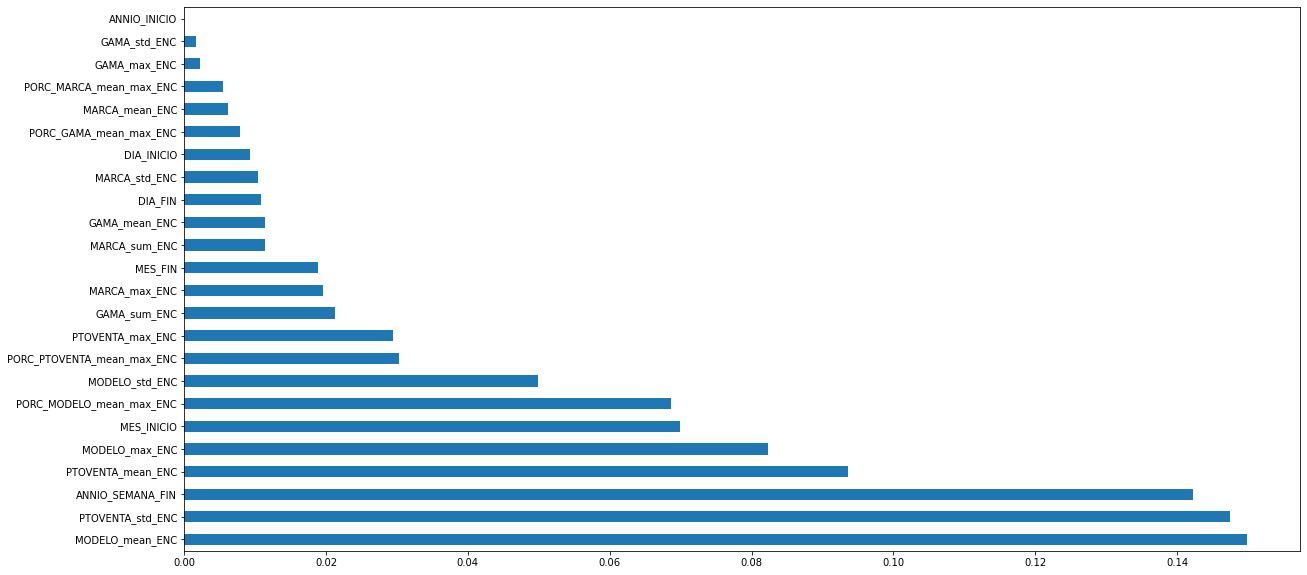

In [63]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

In [64]:
features_importances = pd.Series(learner_lg.feature_importances_ / learner_lg.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 24
variables con importancia acumulada al 99% : 17
variables con zero importancia : 2


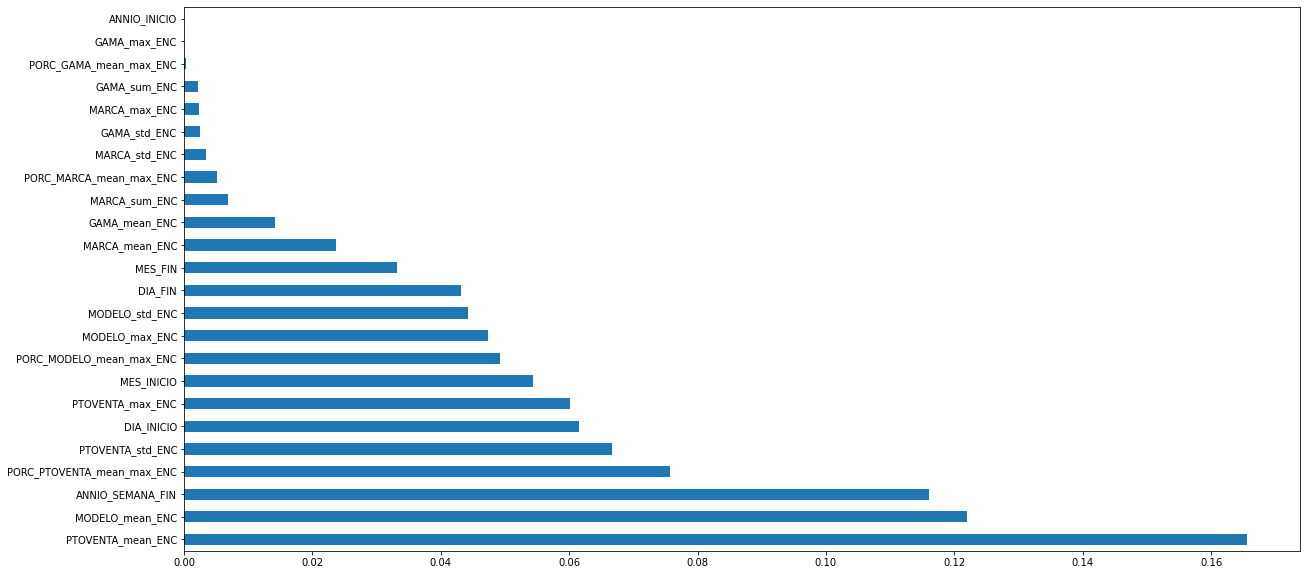

In [65]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

In [66]:
features_importances = pd.Series(learner_xg.feature_importances_ / learner_xg.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 24
variables con importancia acumulada al 99% : 18
variables con zero importancia : 3


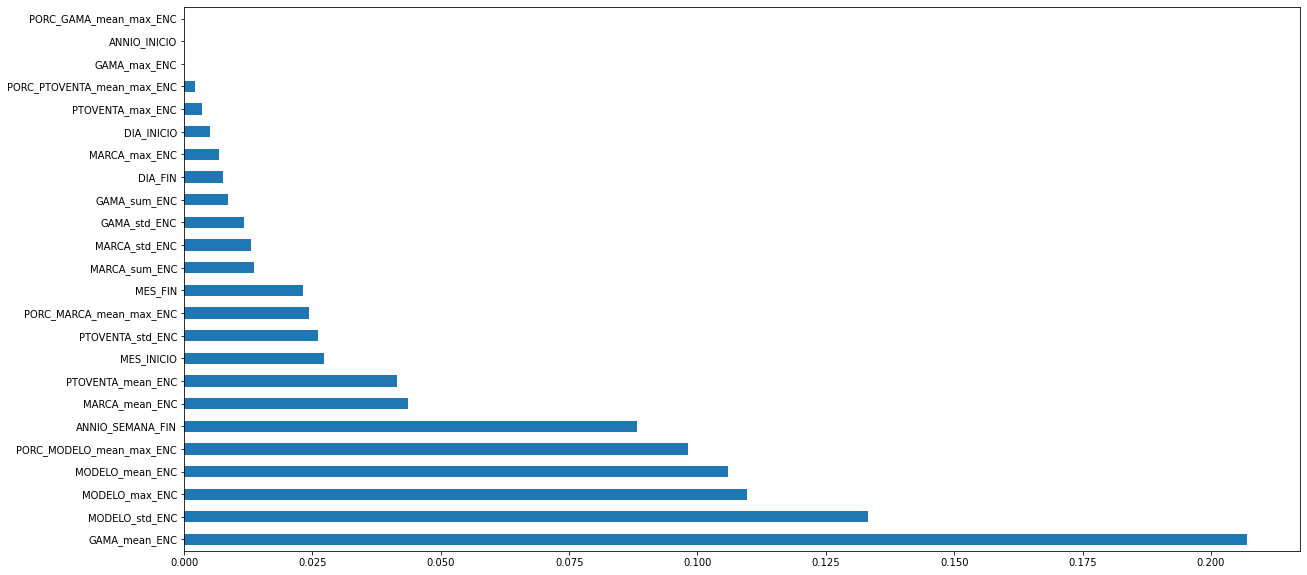

In [67]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

### SUBMISION 

In [68]:
if 'Demanda' in test.columns:
    test.drop(['Demanda'], axis=1, inplace=True)

In [69]:
test['Demanda'] = learner_lg.predict(test)*0.35 + learner_cb.predict(test)*0.30 +  learner_xg.predict(test)*0.35
# test['Demanda'] = learner_lg.predict(test)*0.5 + learner_xg.predict(test)*0.5
# test['Demanda'] = learner_lg.predict(test)
# test['Demanda'] = learner_cb.predict(test)
# test['Demanda'] = learner_xg.predict(test)
test['Demanda'] = test['Demanda'].apply(lambda x: 0 if x<0 else x)

In [70]:
test_submit = test.reset_index()[['ID','Demanda']]
test_submit

,ID,Demanda
0,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.231810
1,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.218549
2,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.221562
3,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.224659
4,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.245219
...,...,...
471725,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.026380
471726,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.025473
471727,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.021027
471728,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.025356


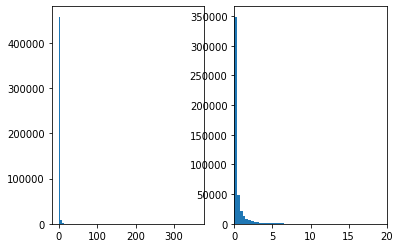

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test['Demanda'], bins=100);
ax2.hist(test['Demanda'], bins=1000);
plt.xlim(0,20);

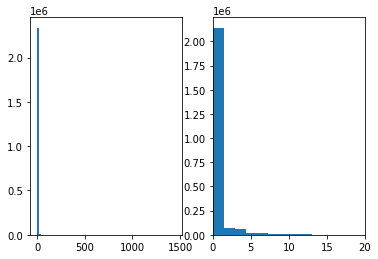

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [73]:
test_submit.to_csv('../results/ensamble_fulldata_xg_lg_cb.csv', index=False)
test_submit['Demanda'].describe()

count    471730.000000
mean          0.618205
std           3.070244
min           0.000000
25%           0.017937
50%           0.110588
75%           0.381740
max         360.150445
Name: Demanda, dtype: float64

In [74]:
!kaggle competitions submit datathon-entel-2022-reto2 -f ../results/ensamble_fulldata_xg_lg_cb.csv -m "test"

Successfully submitted to DATATHON ENTEL 2022 - Reto2



  0%|          | 0.00/100M [00:00<?, ?B/s]
  0%|          | 8.00k/100M [00:00<31:39, 55.4kB/s]
  0%|          | 96.0k/100M [00:00<04:04, 431kB/s] 
  0%|          | 368k/100M [00:00<01:24, 1.25MB/s]
  1%|          | 864k/100M [00:00<00:41, 2.54MB/s]
  2%|1         | 1.77M/100M [00:00<00:21, 4.88MB/s]
  2%|2         | 2.28M/100M [00:00<00:23, 4.38MB/s]
  3%|2         | 2.76M/100M [00:00<00:22, 4.55MB/s]
  3%|3         | 3.22M/100M [00:00<00:22, 4.60MB/s]
  4%|3         | 3.68M/100M [00:01<00:33, 3.04MB/s]
  4%|4         | 4.05M/100M [00:01<00:34, 2.92MB/s]
  4%|4         | 4.40M/100M [00:01<01:05, 1.53MB/s]
  5%|4         | 4.65M/100M [00:02<01:06, 1.50MB/s]
  5%|5         | 5.16M/100M [00:02<00:49, 2.01MB/s]
  5%|5         | 5.50M/100M [00:02<00:44, 2.26MB/s]
  6%|5         | 5.99M/100M [00:02<00:35, 2.80MB/s]
  6%|6         | 6.44M/100M [00:02<00:30, 3.18MB/s]
  7%|6         | 6.85M/100M [00:02<00:28, 3.45MB/s]
  7%|7         | 7.28M/100M [00:02<00:26, 3.67MB/s]
  8%|7         | 7.73M

In [75]:
test_submit_stacking= pd.read_csv('../results/test_stacking_xg_cb_lg_training_xg_cv.csv')
test_submit_stacking['Demanda'].describe()

count    471730.000000
mean          0.668325
std           2.438453
min           0.070592
25%           0.180210
50%           0.264086
75%           0.516798
max         224.080734
Name: Demanda, dtype: float64

In [76]:
test_submit['Demanda'] = test_submit_stacking['Demanda']*0.5 + test_submit['Demanda']*0.5
test_submit['Demanda'].describe()

count    471730.000000
mean          0.643265
std           2.714438
min           0.036678
25%           0.106943
50%           0.193305
75%           0.451973
max         291.966841
Name: Demanda, dtype: float64

In [77]:
test_submit.to_csv('../results/ensamble_fulldata_stacking_xg_lg_cb.csv', index=False)

In [78]:
!kaggle competitions submit datathon-entel-2022-reto2 -f ../results/ensamble_fulldata_stacking_xg_lg_cb.csv -m "test"

Successfully submitted to DATATHON ENTEL 2022 - Reto2



  0%|          | 0.00/101M [00:00<?, ?B/s]
  0%|          | 8.00k/101M [00:00<31:36, 56.1kB/s]
  0%|          | 96.0k/101M [00:00<04:04, 434kB/s] 
  0%|          | 240k/101M [00:00<02:13, 795kB/s] 
  1%|          | 616k/101M [00:00<01:00, 1.76MB/s]
  1%|          | 872k/101M [00:00<00:51, 2.03MB/s]
  1%|1         | 1.18M/101M [00:00<00:42, 2.46MB/s]
  1%|1         | 1.50M/101M [00:00<00:39, 2.68MB/s]
  2%|1         | 1.90M/101M [00:00<00:33, 3.11MB/s]
  2%|2         | 2.52M/101M [00:01<00:25, 4.12MB/s]
  3%|2         | 2.95M/101M [00:01<00:24, 4.15MB/s]
  3%|3         | 3.37M/101M [00:01<00:24, 4.20MB/s]
  4%|3         | 3.79M/101M [00:01<00:24, 4.22MB/s]
  4%|4         | 4.23M/101M [00:01<00:23, 4.32MB/s]
  5%|4         | 4.64M/101M [00:01<00:23, 4.30MB/s]
  5%|5         | 5.08M/101M [00:01<00:23, 4.33MB/s]
  5%|5         | 5.49M/101M [00:01<00:24, 4.03MB/s]
  6%|5         | 5.88M/101M [00:01<00:24, 4.04MB/s]
  6%|6         | 6.27M/101M [00:01<00:25, 3.91MB/s]
  7%|6         | 6.72M/